In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, iirnotch, filtfilt, stft
import csv

from ipywidgets import DOMWidget, widget_serialization
from matplotlib import is_interactive, rcParams
from matplotlib._pylab_helpers import Gcf
from matplotlib.backend_bases import NavigationToolbar2, _Backend, cursors
from matplotlib.backends.backend_webagg_core import (
    FigureCanvasWebAggCore,
    FigureManagerWebAgg,
    NavigationToolbar2WebAgg,
    TimerTornado,
)
%matplotlib
import ipympl



Using matplotlib backend: module://matplotlib_inline.backend_inline


In [14]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.signal import windows
from scipy.constants import c
from scipy.signal import stft
from scipy.signal import square
from scipy.signal import butter, iirnotch, filtfilt, correlate, lfilter, fftconvolve
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm

import os
import re


In [15]:
# waterfall

def spectrogram_data(complex_data, fs):
    # Compute the Short-Time Fourier Transform (STFT)
    nperseg = 256*8  # Number of samples per segment
    noverlap = nperseg // 8  # Number of overlapping samples
    frequencies, times, Zxx = stft(complex_data, fs=fs, nperseg=nperseg, noverlap=noverlap)


    # Shift the zero frequency component to the center
    Zxx_shifted = np.fft.fftshift(Zxx, axes=0)
    frequencies_shifted = np.fft.fftshift(frequencies)

    # Compute the magnitude of the STFT
    magnitude_spectrogram = np.abs(Zxx_shifted)
    threshold_dB = 40
    threshold = 10**(threshold_dB / 20)  # Convert dB to linear scale

    magnitude_spectrogram_db = 20 * np.log10(magnitude_spectrogram)   
    return times, frequencies_shifted, magnitude_spectrogram_db


def notch_filter(complex_data, fs, q, cutoff, order):
    # Notch filter
    # Parameters
    notch_freq = 0  # Notch filter centered at 0 Hz (DC)
    quality_factor = q  # Q-factor for the notch filter
    cutoff_freq = cutoff  # 
    nyquist_rate = fs / 2
    normalized_cutoff = cutoff_freq / nyquist_rate
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)
    complex_data = filtfilt(b, a, complex_data)
    return complex_data

def median_filter_complex(complex_data, size):
    real_data = median_filter(np.real(complex_data),size)
    imag_data = median_filter(np.imag(complex_data), size)
    return real_data + 1j*imag_data

def read_iq_bin(file_path):
    # Read the binary file
    with open(file_path, 'rb') as file:
        # Read the data into a numpy array
        # The dtype should match the type of data in the file (double = float64)
        data = np.fromfile(file, dtype=np.float64)

    # Reshape or process the data if needed
    # Here we assume data was written as 2 doubles per sample
    num_new_samples = int(len(data)/2)
    data = data.reshape((num_new_samples, 2))

    # Create complex numbers from the real and imaginary parts
    complex_data = data[:, 0] + 1j * data[:, 1]
    return complex_data

def read_complex_csv(file_path):
    complex_data = []
    
    # Open the CSV file for reading
    with open(file_path, 'r', newline='') as csvfile:
        csvreader = csv.reader(csvfile)
        
        # Read each row and reconstruct the complex number
        for row in csvreader:
            if len(row) == 2:
                real_part = float(row[0])
                imag_part = float(row[1])
                complex_number = real_part + 1j * imag_part
                complex_data.append(complex_number)
    
    # Convert the list of complex numbers into a numpy array
    return np.array(complex_data)

def gen_chirp_to_csv(file_path, start, stop, length, separation, amplitude, fs):
    result = []

    for i in range(int(length)):
        t = i / fs
        frequency = start + (stop - start) * i / length
        phase = 2.0 * np.pi * frequency * t
        sample = amplitude * np.exp(1j * phase) + 0j 
        result.append(sample)

    # appending zeros so transmitting is "turned off"
    num_zeros = int(separation)
    for i in range(num_zeros):
        result.append(0)
    result = np.array(result)

    # Write to CSV file
    with open(file_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        for sample in result:
            csvwriter.writerow([sample.real, sample.imag])
    return result

def gen_chirp_to_csv_rep(file_path, start, stop, length, separation, amplitude, fs, num_pulses):
    result = []

    for i in range(int(length)):
        t = i / fs
        frequency = start + (stop - start) * i / length
        phase = 2.0 * np.pi * frequency * t
        sample = amplitude * np.exp(1j * phase) + 0j 
        result.append(sample)

    # appending zeros so transmitting is "turned off"
    num_zeros = int(separation)
    for i in range(num_zeros):
        result.append(0)
    result = np.array(result)
    result = np.tile(result, num_pulses)

    # Write to CSV file
    with open(file_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        for sample in result:
            csvwriter.writerow([sample.real, sample.imag])
    return result


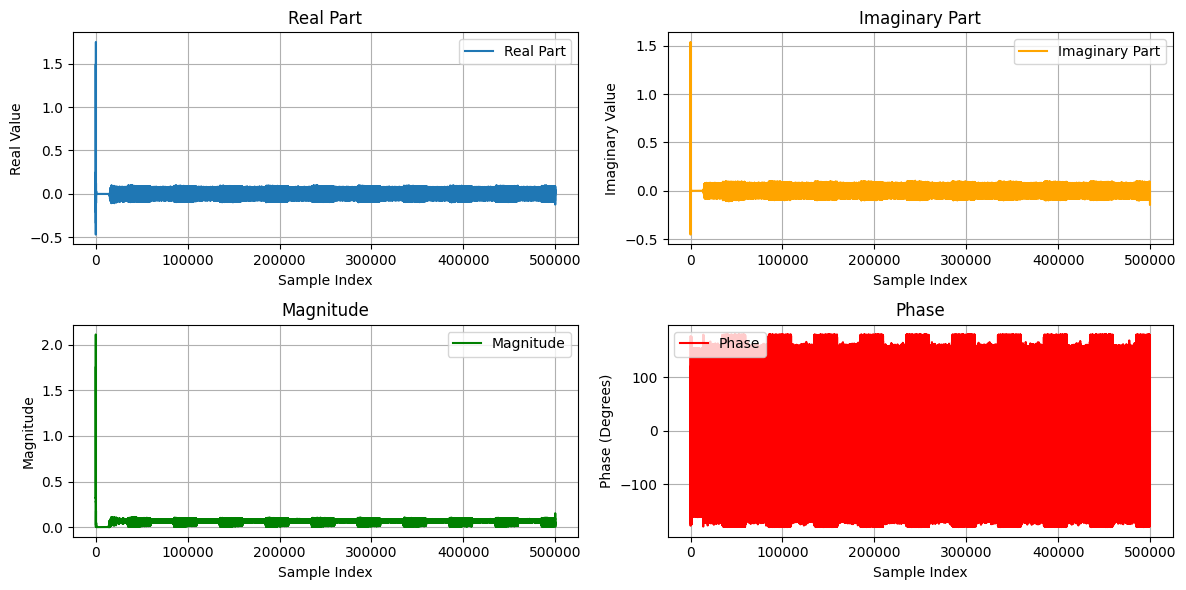

In [162]:
fs = 25e6

# Define the path to your binary file
file_path = 'outputs/pulsed_test.bin'


complex_data = read_iq_bin(file_path)
complex_data = notch_filter(complex_data, fs, 10, 0.1e6, 4)
#complex_data = median_filter_complex(complex_data,5)


# Compute magnitude and phase
magnitudes = np.abs(complex_data)
phases = np.angle(complex_data, deg=True)  # Phase in degrees

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot real part
real = np.real(complex_data)
#real = moving_average_filter(real,10)
axs[0, 0].plot(real, label='Real Part')
axs[0, 0].set_title('Real Part')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Real Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot imaginary part
axs[0, 1].plot(np.imag(complex_data), label='Imaginary Part', color='orange')
axs[0, 1].set_title('Imaginary Part')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Imaginary Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot magnitude
axs[1, 0].plot(magnitudes, label='Magnitude', color='green')
axs[1, 0].set_title('Magnitude')
axs[1, 0].set_xlabel('Sample Index')
axs[1, 0].set_ylabel('Magnitude')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot phase
axs[1, 1].plot(phases, label='Phase', color='red')
axs[1, 1].set_title('Phase')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Phase (Degrees)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


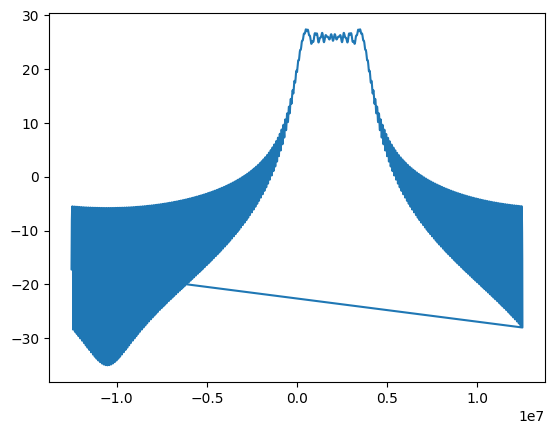

In [74]:
fs = 25e6
B = 2e6
result = gen_chirp_to_csv_rep("sweep.csv", 0, B, 250, 2500, 0.5, fs, 1)


fft_data = np.fft.fft(result)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)
plt.plot(fft_freq_axis, 20*np.log10(fft_data))
plt.show()


In [ ]:

#
# Save the signal to a file ################
# Step 1: Separate real and imaginary parts
waveformTimeDomain = result
real_part = np.real(waveformTimeDomain)
imag_part = np.imag(waveformTimeDomain)

# Step 2: Interleave real and imaginary parts
interleaved_array = np.empty((real_part.size + imag_part.size,), dtype=np.float64)
interleaved_array[0::2] = real_part
interleaved_array[1::2] = imag_part

# Step 3: Save the interleaved array to a .dat file
interleaved_array.tofile('murray_cw.dat')

# Step 1: Load the binary data from the .dat file
loaded_array = np.fromfile('murray_cw.dat', dtype=np.float64)
print(loaded_array)
# Step 2: Check the length of the loaded array
length = len(loaded_array)

# Step 3: Calculate the number of complex numbers (each complex number has 2 floats)
num_complex_numbers = length // 2

print(f"Length of the loaded array: {length}")
print(f"Number of complex numbers: {num_complex_numbers}")
###########################################################


loaded_arr1 = np.zeros(length//2)
loaded_arr1 = loaded_array[0:length:2] + 1j * loaded_array[1:length:2]

plt.plot(loaded_arr1)
plt.show()
#plt.plot(loaded_array)
#plt.show()

fft_data = np.fft.fft(loaded_arr1)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)
plt.plot(fft_freq_axis, 20*np.log10(fft_data))
plt.show()


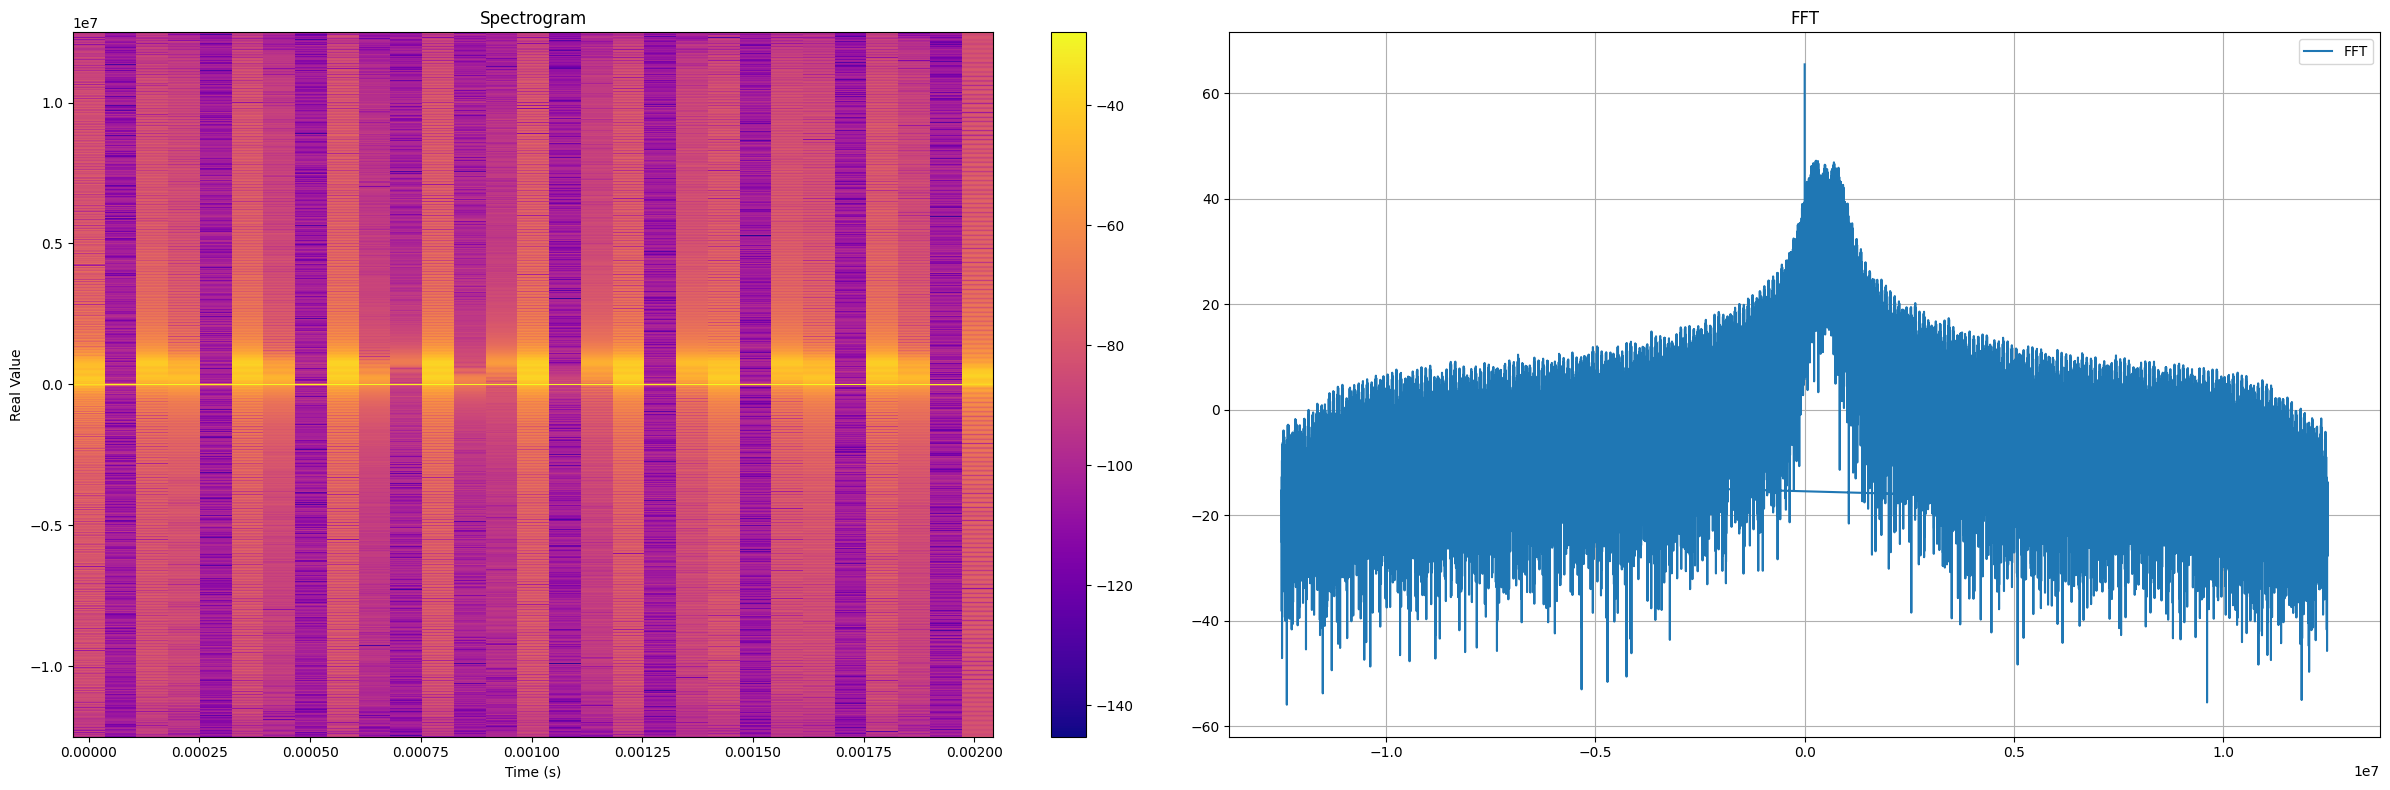

In [13]:
file_path = 'outputs/pulsed_test.bin'
fs = 25e6


complex_data = read_iq_bin(file_path)
#complex_data = notch_filter(complex_data, fs, 10, 0.1e6, 2)
#complex_data = bandpass_filter(complex_data, 4.5e6, 7.5e6, fs, 4)

# Plotting spectrogram
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
times, frequencies_shifted, magnitude_spectrogram_db = spectrogram_data(complex_data,fs)
cax0 = axs[0].pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
#axs[0].set_colorbar(label='Magnitude (dB)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Real Value')
axs[0].set_title('Spectrogram')

# plotting fft
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude)


axs[1].plot(fft_freq_axis, magnitude_db, label='FFT')
axs[1].set_title('FFT')
axs[1].legend()
axs[1].grid(True)

fig.colorbar(cax0, ax=axs[0])
plt.tight_layout()
plt.show()


1816


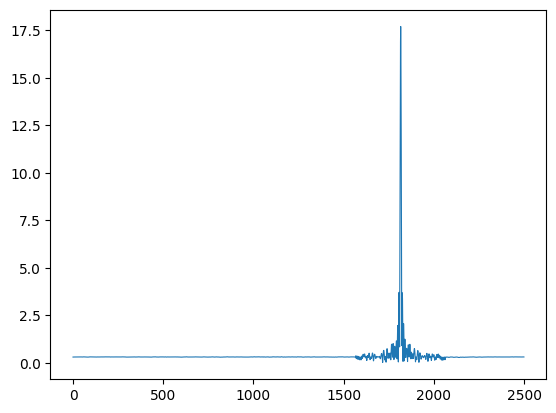

5e-07


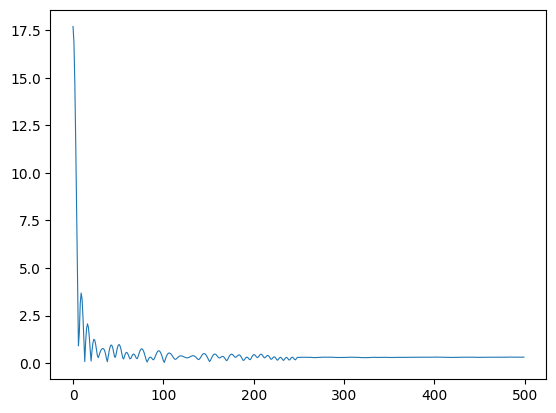

In [190]:
data = read_iq_bin("outputs/pulsed_test.bin")
template_signal = read_complex_csv("sweep.csv")
pulse_width = 250
template_signal = template_signal[0:pulse_width]

matched_filter = np.conjugate(template_signal[::-1])
xcorr_data = fftconvolve(data, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] # Artifact at start
xcorr_data = xcorr_data[0:2500]
max_idx = np.argmax(np.abs(xcorr_data))
print(max_idx)
plt.plot(np.abs(xcorr_data),linewidth=0.8)
plt.show()
print(1/B)
xcorr_data = xcorr_data[max_idx:max_idx+500]
plt.plot(np.abs(xcorr_data),linewidth=0.8)
plt.show()

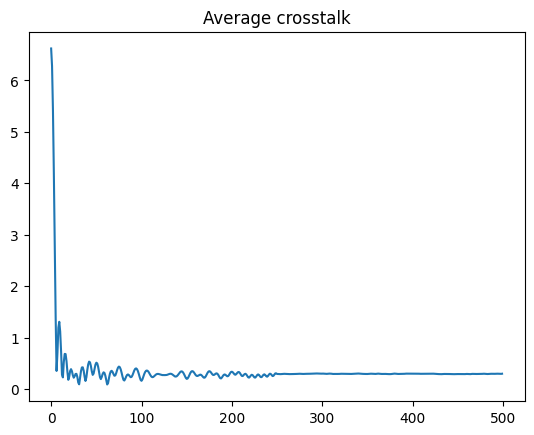

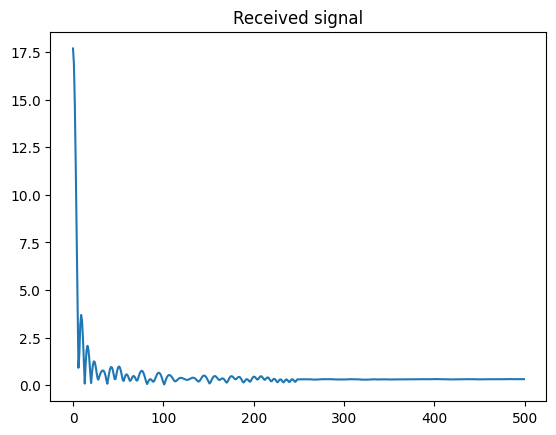

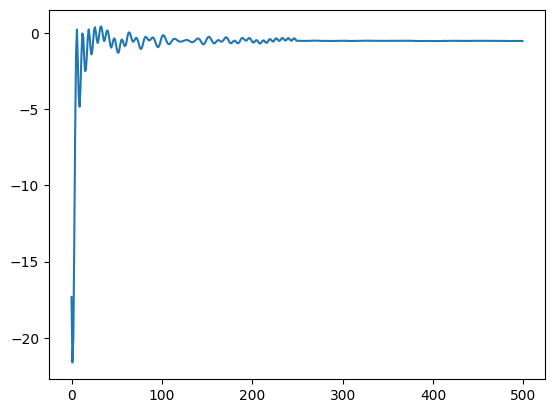

In [198]:
def extract_signals_from_bin(file_path, N):
    # Check if file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")

    # Read the file in binary mode
    with open(file_path, 'rb') as f:
        data = np.fromfile(f, dtype=np.float64)


    # Split into chunks of size N
    offset = len(data) % N
    if offset != 0:
        data = data[0:-offset]
    

    num_chunks = len(data) // N
    data = data.reshape((num_chunks, N))

    return data

crosstalk_mat = extract_signals_from_bin("outputs/crosstalk.bin", 500)
average_signal = np.mean(crosstalk_mat, axis=0)
plt.plot(average_signal)
plt.title("Average crosstalk")
plt.show()

data = read_iq_bin("outputs/pulsed_test.bin")
template_signal = read_complex_csv("sweep.csv")
pulse_width = 250
template_signal = template_signal[0:pulse_width]

matched_filter = np.conjugate(template_signal[::-1])
xcorr_data = fftconvolve(data, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] # Artifact at start
xcorr_data = xcorr_data[0:2500]
max_idx = np.argmax(np.abs(xcorr_data))
xcorr_data = xcorr_data[max_idx:max_idx+500]
plt.plot(np.abs(xcorr_data))
plt.title("Received signal")
plt.show()

diff = xcorr_data - average_signal
plt.plot(np.abs(diff))